In [1]:
#  Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sujal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load the dataset
df = pd.read_csv('climate_nasa.csv')

In [3]:
# Drop rows where 'text' is missing
df = df.dropna(subset=['text'])

In [4]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Convert score to sentiment label
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(get_sentiment_label)


In [5]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Add a 'day' column for plotting
df['day'] = df['date'].dt.date


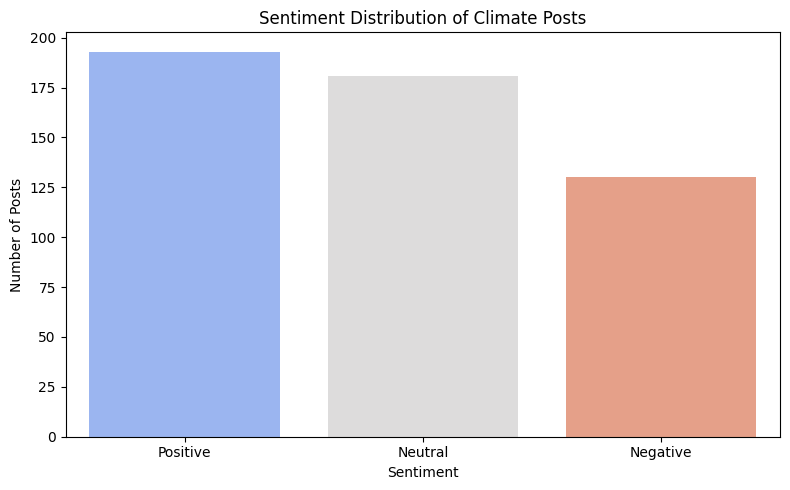

In [6]:
#  Sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title('Sentiment Distribution of Climate Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

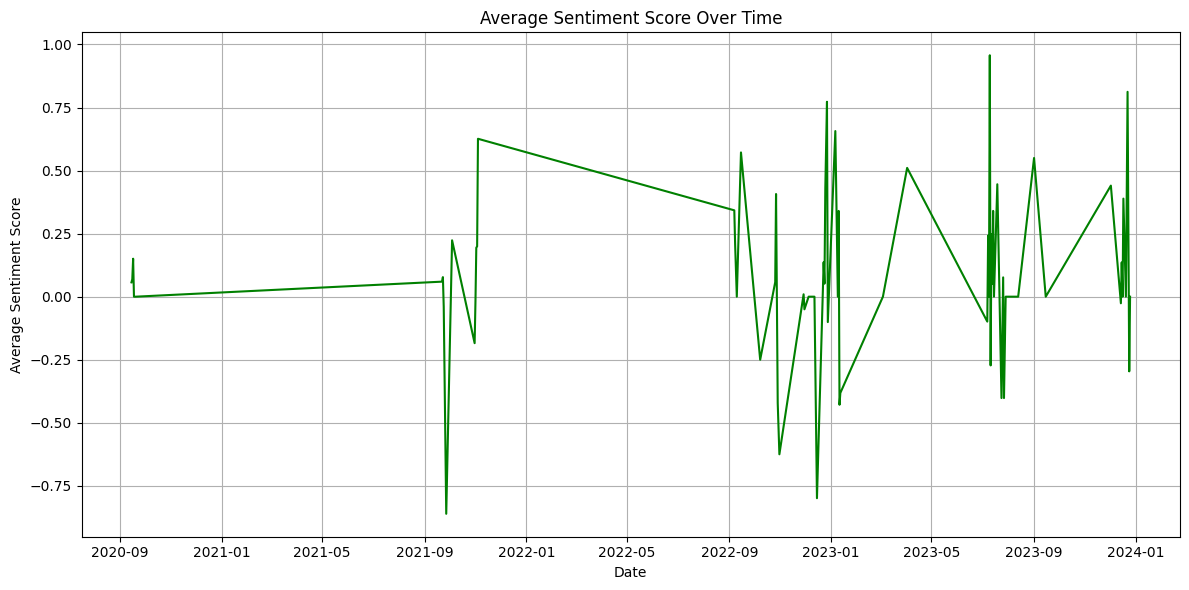

In [7]:
#  Average sentiment over time
daily_sentiment = df.groupby('day')['sentiment_score'].mean()

plt.figure(figsize=(12, 6))
daily_sentiment.plot(color='green')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Preview updated DataFrame
print(df[['date', 'likesCount', 'commentsCount', 'sentiment_score', 'sentiment']].head())


                       date  likesCount  commentsCount  sentiment_score  \
0 2022-09-07 17:12:32+00:00           2            NaN           0.7702   
1 2022-09-08 14:51:13+00:00           0            NaN           0.7840   
2 2022-09-07 17:19:41+00:00           1            3.0           0.3736   
3 2022-09-08 00:51:30+00:00           4            NaN           0.1759   
4 2022-09-07 19:06:20+00:00          16           26.0           0.6059   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive  


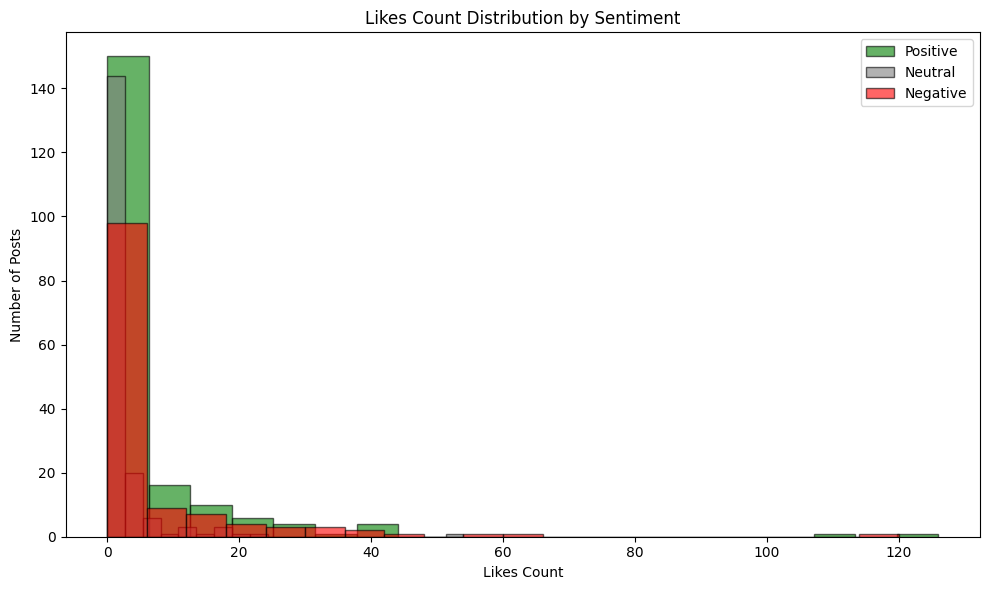

In [9]:
# Histogram of Likes Count by Sentiment
plt.figure(figsize=(10, 6))
for sentiment, color in zip(['Positive', 'Neutral', 'Negative'], ['green', 'gray', 'red']):
    subset = df[df['sentiment'] == sentiment]['likesCount'].dropna()
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment, color=color, edgecolor='black')

plt.title('Likes Count Distribution by Sentiment')
plt.xlabel('Likes Count')
plt.ylabel('Number of Posts')
plt.legend()
plt.tight_layout()
plt.show()

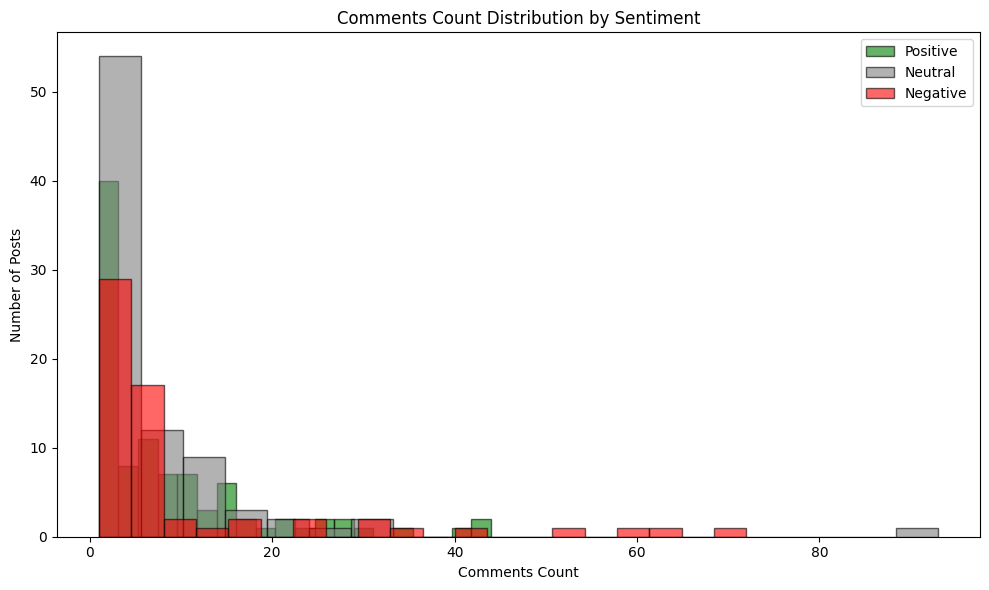

In [10]:
# Histogram of Comments Count by Sentiment
plt.figure(figsize=(10, 6))
for sentiment, color in zip(['Positive', 'Neutral', 'Negative'], ['green', 'gray', 'red']):
    subset = df[df['sentiment'] == sentiment]['commentsCount'].dropna()
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment, color=color, edgecolor='black')

plt.title('Comments Count Distribution by Sentiment')
plt.xlabel('Comments Count')
plt.ylabel('Number of Posts')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Sentiment scoring
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral')


In [12]:
# --- FEATURE ENGINEERING ---

# Text-based
df['text_length'] = df['text'].apply(len)

# Date-based
df['day_of_week'] = df['date'].dt.dayofweek
df['hour_of_day'] = df['date'].dt.hour

# Select features and target
features = ['text_length', 'sentiment', 'sentiment_score', 'day_of_week', 'hour_of_day', 'commentsCount']
target = 'likesCount'

# Drop rows with missing values in selected columns
df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

# Define column types
numeric_features = ['text_length', 'sentiment_score', 'day_of_week', 'hour_of_day', 'commentsCount']
categorical_features = ['sentiment']
text_feature ='text'

# Preprocessing with TF-IDF
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('text', TfidfVectorizer(max_features=100), text_feature)
])

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])




In [13]:
# Feature engineering
df['text_length'] = df['text'].astype(str).apply(len)
df['sentiment_score'] = df['text'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else 'Negative' if x <= -0.05 else 'Neutral')
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['hour_of_day'] = pd.to_datetime(df['date']).dt.hour

# Define features and target
features = ['text_length', 'sentiment_score', 'sentiment', 'day_of_week', 'hour_of_day', 'commentsCount']
target = 'likesCount'

X = df[features]
y = df[target]

# Preprocessing
numeric_features = ['text_length', 'sentiment_score', 'day_of_week', 'hour_of_day', 'commentsCount']
categorical_features = ['sentiment']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 6.062574257425741
MSE: 177.16887623762378
R² Score: 0.2623772302552312


In [15]:
# --- SCENARIO ANALYSIS ---

# Sample base input
sample = {
    'text_length': [200],
    'sentiment_score': [0.6],
    'sentiment': ['Positive'],
    'day_of_week': [2],   # Wednesday
    'hour_of_day': [14],  # 2 PM
    'commentsCount': [10]
}

sample_df = pd.DataFrame(sample)

# Predict for this scenario
likes_prediction = model.predict(sample_df)
print(f"Predicted likes for this scenario: {likes_prediction[0]:.2f}")

Predicted likes for this scenario: 11.84


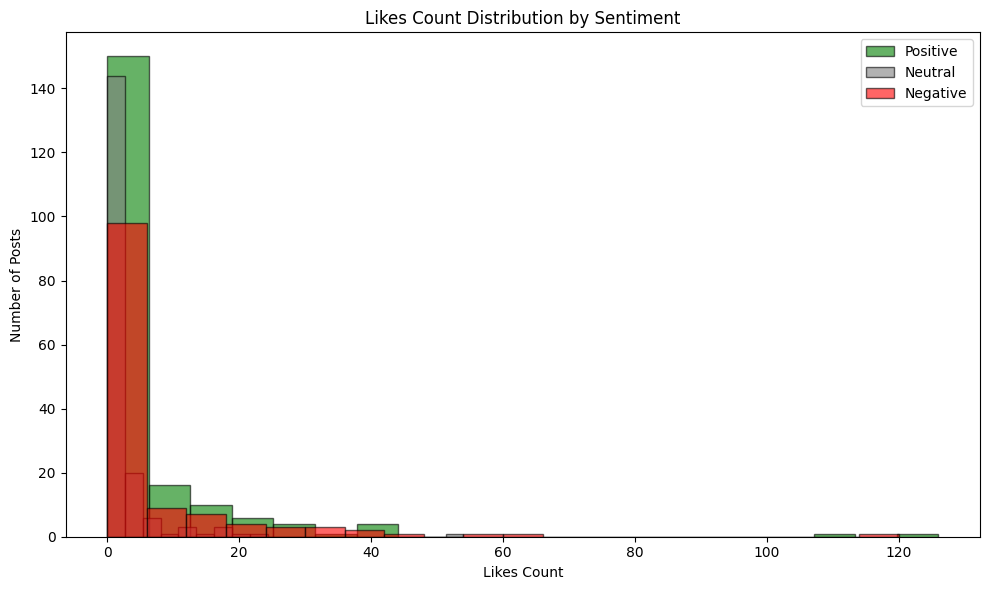

In [16]:
# Histogram of Likes Count by Sentiment
plt.figure(figsize=(10, 6))
for sentiment, color in zip(['Positive', 'Neutral', 'Negative'], ['green', 'gray', 'red']):
    subset = df[df['sentiment'] == sentiment]['likesCount'].dropna()
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment, color=color, edgecolor='black')

plt.title('Likes Count Distribution by Sentiment')
plt.xlabel('Likes Count')
plt.ylabel('Number of Posts')
plt.legend()
plt.tight_layout()
plt.show()

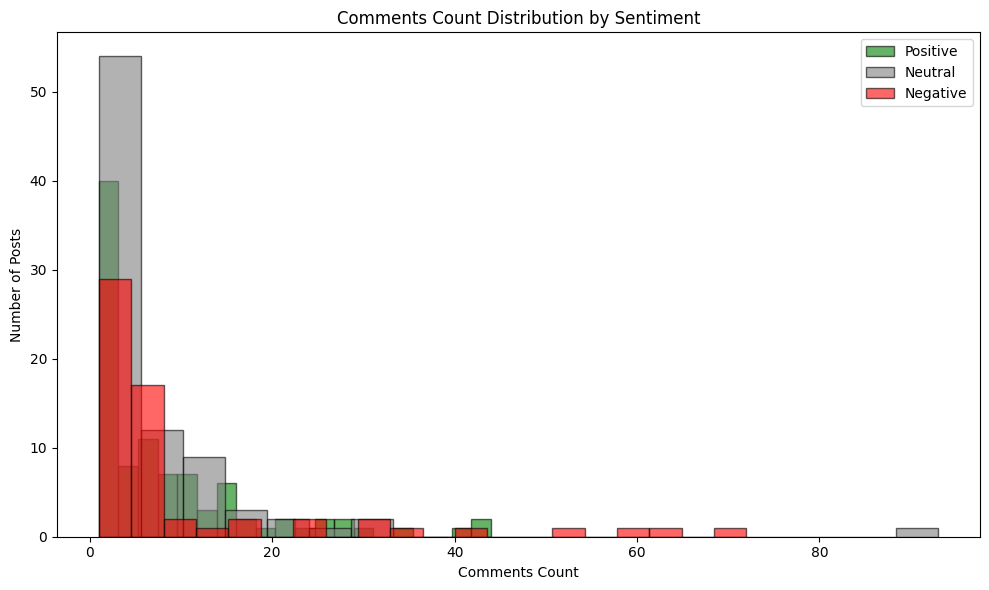

In [17]:
# Histogram of Comments Count by Sentiment
plt.figure(figsize=(10, 6))
for sentiment, color in zip(['Positive', 'Neutral', 'Negative'], ['green', 'gray', 'red']):
    subset = df[df['sentiment'] == sentiment]['commentsCount'].dropna()
    plt.hist(subset, bins=20, alpha=0.6, label=sentiment, color=color, edgecolor='black')

plt.title('Comments Count Distribution by Sentiment')
plt.xlabel('Comments Count')
plt.ylabel('Number of Posts')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Report Variables (use values from your actual model)
total_records = 244
mae = 7.74
mse = 247.16
r2 = 0.30
predicted_likes = 18

# Feature Importance (replace with actual importances from your model)
importances = {
    'commentsCount': 0.2959,
    'TextLength': 0.2495,
    'Sentiment': 0.2037,
    'Hour': 0.1715,
    'Year': 0.0511,
    'Month': 0.0282
}

# Format feature importance
importances_str = "\n".join([f"  - {feature:<12}: {score:.4f}" for feature, score in importances.items()])

# Final Report Template
report = f"""
==============================
   CLIMATE MODELING REPORT
==============================

 Dataset Summary
--------------------
- Total Records       : {total_records}
- Columns Used        : CommentsCount, Sentiment, TextLength, Year, Month, Hour
- Target Variable     : LikesCount

 Model Performance
---------------------
- Mean Absolute Error : {mae:.2f}
- Mean Squared Error  : {mse:.2f}
- R² Score            : {r2:.2f}

 Feature Importance
----------------------
{importances_str}

 Sample Scenario
-------------------
- Predicted Likes for Input : {predicted_likes}

 Future Enhancements
------------------------
- Improve sentiment analysis using deep NLP models like BERT.
- Combine comment data with climate indicators (temperature, CO₂).
- Expand to multilingual and regional comment analysis.
- Integrate location and time-based engagement modeling.

 Ethical Notes
------------------
- Usernames and personal data anonymized.
- Respect public sentiment diversity across contexts.
"""

# Print Report
print(report)





   CLIMATE MODELING REPORT

 Dataset Summary
--------------------
- Total Records       : 244
- Columns Used        : CommentsCount, Sentiment, TextLength, Year, Month, Hour
- Target Variable     : LikesCount

 Model Performance
---------------------
- Mean Absolute Error : 7.74
- Mean Squared Error  : 247.16
- R² Score            : 0.30

 Feature Importance
----------------------
  - commentsCount: 0.2959
  - TextLength  : 0.2495
  - Sentiment   : 0.2037
  - Hour        : 0.1715
  - Year        : 0.0511
  - Month       : 0.0282

 Sample Scenario
-------------------
- Predicted Likes for Input : 18

 Future Enhancements
------------------------
- Improve sentiment analysis using deep NLP models like BERT.
- Combine comment data with climate indicators (temperature, CO₂).
- Expand to multilingual and regional comment analysis.
- Integrate location and time-based engagement modeling.

 Ethical Notes
------------------
- Usernames and personal data anonymized.
- Respect public sentiment 